Answer to 1: determine the sentiment polarity and name using textblob




In [26]:
pip install textblob


In [127]:
import pandas as pd
from textblob import TextBlob
df = pd.read_csv('Dataset.csv')

In [28]:


# Create a function to calculate sentiment score
def calculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the sentiment analysis function
df['TextBlob_Polarity_Score'] = df['Review_Text'].apply(calculate_sentiment)

# Save the result as vector V1
V1 = df['TextBlob_Polarity_Score']
df_textblob = df.copy()


In [29]:


# Create a function to classify sentiment
def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Calculate sentiment scores using TextBlob
df_textblob['TextBlob_Polarity_Score'] = df_textblob['Review_Text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Create 'textblob_sentiment' column based on sentiment classification
df_textblob['Textblob_Sentiment'] = df['TextBlob_Polarity_Score'].apply(classify_sentiment)
df_textblob.head(5)


,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score,Textblob_Sentiment
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...,0.773333,positive
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...,0.273661,positive
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...,0.268750,positive
3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...,0.381250,positive
4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...,0.354082,positive


Sentiment Trends Over Time (TextBlob)

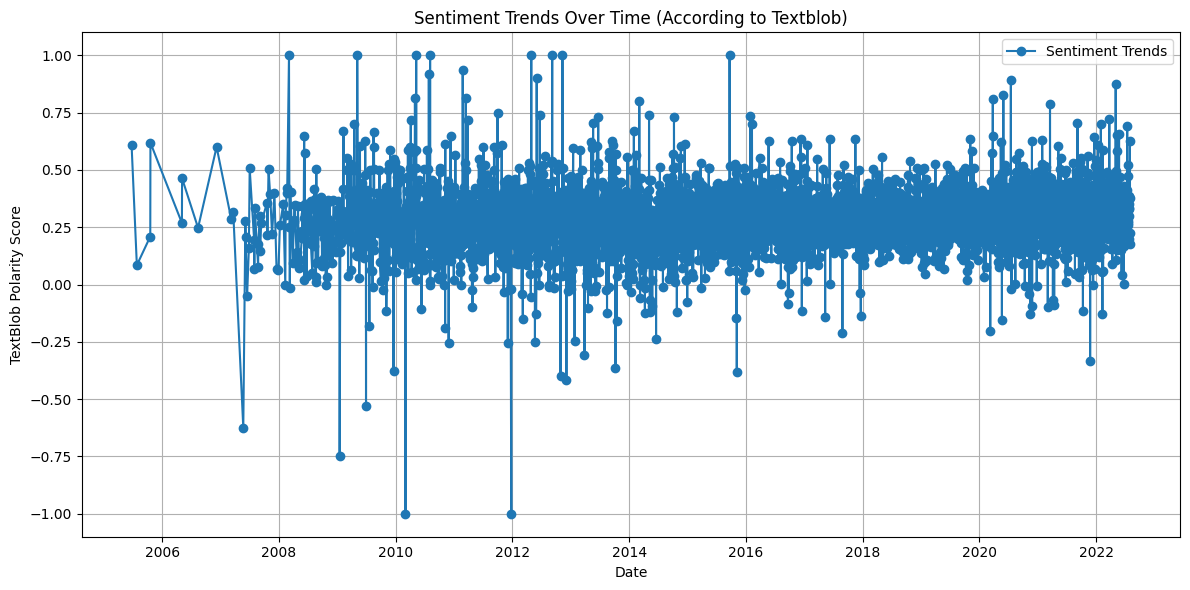

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Date' column to a datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date (if not already sorted)
df = df.sort_values(by='Date')

# Group data by date and calculate the mean sentiment for each day
daily_sentiment = df.groupby('Date')['TextBlob_Polarity_Score'].mean()

# Create a line chart for sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values, label='Sentiment Trends', marker='o', linestyle='-')
plt.title('Sentiment Trends Over Time (According to Textblob)')
plt.xlabel('Date')
plt.ylabel('TextBlob Polarity Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
#plt.show()
plt.savefig('Sentiment Trends Over Time (According to Textblob).png', dpi=1000)


Answer mo 2: calculate the sentiment names based on BOW+logistic and LSTM

In [31]:
!pip install contractions

In [32]:
# Data preparation and text-preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [33]:
#### text preprocessing
def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

In [34]:
#### text preprocessing

def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

    ## Next step is text-normalization

    # Text normalization includes many steps.

    # Each function below serves a step.


    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words


    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words


    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words


    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems


    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas


    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # All above functions work on word tokens we need a tokenizer


    def tokenize(text):
        return nltk.word_tokenize(text)


    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text

    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]


    # return processed df
    return df

In [35]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:
processed_df = text_preprocessing_platform(df, 'Review_Text', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['Review_Text']])

<ipython-input-34-43c795c4a652>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


After Text Preprocessing


,Review_Text
12228,know cleveland italian neighborhood beautiful ...
12219,drunken clevelanders emerge party bar east sid...
14794,open warmer weather designyourown custard crea...
14837,custard cup friends place go summer best taste...
12097,would know previous three review place actuall...


In [38]:
df.head(2)

,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score
12228,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2005-06-24,know cleveland italian neighborhood beautiful ...,0.608854
12219,https://www.yelp.com/biz/prestis-bakery-cleveland,5,2005-07-27,drunken clevelanders emerge party bar east sid...,0.084375


In [39]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('Dataset.csv')

# Define a function to map numeric ratings to sentiment names
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

# Map the 'Rating' column to Users_Sentiment
df['Users_Sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

# Split your data into training and testing sets (adjust the split ratio as needed)
X_train, X_test, y_train, y_test = train_test_split(df['Review_Text'], df['Users_Sentiment'], test_size=0.2, random_state=42)

# Create a Bag-of-Words representation of the text data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Create a Logistic Regression model
logistic_regression = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)

# Train the model on the training data
logistic_regression.fit(X_train_bow, y_train)

# Predict sentiment labels for the test data
logistic_regression_predictions = logistic_regression.predict(X_test_bow)

# Add the predicted sentiment labels to the DataFrame
df['BoW_Predicted_Sentiment'] = logistic_regression.predict(vectorizer.transform(df['Review_Text']))

df_BOW = df.copy()
# Save the DataFrame with the sentiment names as a new CSV file
#df.to_csv('sentiment_results.csv', index=False)


In [56]:

df_BOW.head(5)

,Yelp URL,Rating,Date,Review_Text,Users_Sentiment,BoW_Predicted_Sentiment
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...,positive,positive
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...,positive,positive
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...,positive,positive
3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...,positive,positive
4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...,positive,positive


ML Model using BoW+Logistic Regression

Accuracy: 0.8552763819095477
Precision: 0.84780942629887
Recall: 0.8552763819095477
F1 Score: 0.8510606598777188


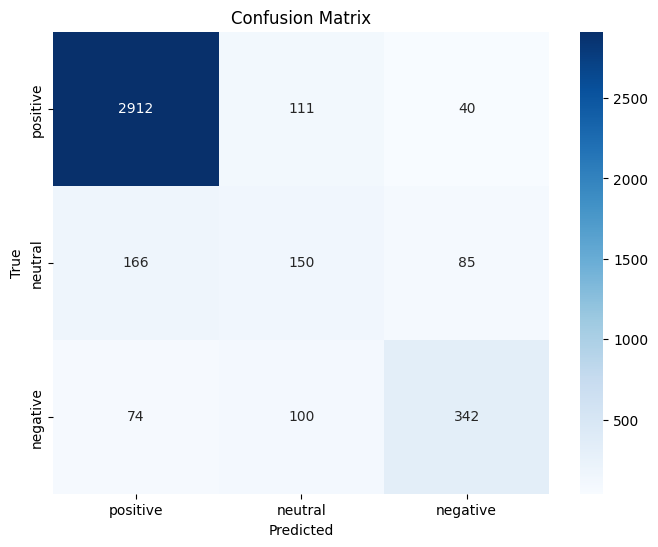

In [72]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Dataset.csv')

# Define a function to map numeric ratings to sentiment names
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

# Map the 'Rating' column to Users_Sentiment
df['Users_Sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

# Split your data into training and testing sets (adjust the split ratio as needed)
X_train, X_test, y_train, y_test = train_test_split(df['Review_Text'], df['Users_Sentiment'], test_size=0.2, random_state=42)

# Create a Bag-of-Words representation of the text data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Create a Logistic Regression model
logistic_regression = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)

# Train the model on the training data
logistic_regression.fit(X_train_bow, y_train)

# Predict sentiment labels for the test data
logistic_regression_predictions = logistic_regression.predict(X_test_bow)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, logistic_regression_predictions)
precision = precision_score(y_test, logistic_regression_predictions, average='weighted')
recall = recall_score(y_test, logistic_regression_predictions, average='weighted')
f1 = f1_score(y_test, logistic_regression_predictions, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Create and plot a confusion matrix
conf_matrix = confusion_matrix(y_test, logistic_regression_predictions, labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Save the DataFrame with the sentiment names as a new CSV file
# df.to_csv('sentiment_results.csv', index=False)


sentiment analysis using an Averaged Embeddings approach and Logistic Regression including loading pre-trained embeddings from spaCy.

In [41]:
!pip install pandas scikit-learn spacy
!python -m spacy download en_core_web_md


2023-11-01 07:57:20.058437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 07:57:20.058522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 07:57:20.058610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 07:57:21.473605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [60]:
import pandas as pd
import spacy
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('Dataset.csv')

# Load the spaCy model with pre-trained word embeddings
nlp = spacy.load('en_core_web_md')

# Define a function to create averaged word embeddings for each review text
def averaged_word_embeddings(text):
    doc = nlp(text)
    vector_sum = np.zeros(len(doc[0].vector))
    word_count = 0
    for token in doc:
        vector_sum += token.vector
        word_count += 1
    if word_count > 0:
        return vector_sum / word_count
    else:
        return np.zeros(len(vector_sum))

# Create averaged embeddings for your dataset using the spaCy model
df['Averaged Embeddings'] = df['Review_Text'].apply(averaged_word_embeddings)


In [64]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Averaged Embeddings'], df['Rating'], test_size=0.2, random_state=42)

# Create and train a Logistic Regression model
logistic_regression = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
logistic_regression.fit(X_train.tolist(), y_train)

# Predict ratings for all reviews
logistic_regression_predictions = logistic_regression.predict(df['Averaged Embeddings'].tolist())

# Add the predicted ratings to the DataFrame
df['AvgEmbedding_Predicted_Rating'] = logistic_regression_predictions
df_AvgEmbedding = df.copy()
# Save the DataFrame with the predicted ratings as a new CSV file
#df.to_csv('predicted_ratings_with_embeddings.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
df_AvgEmbedding.head(2)

,Yelp URL,Rating,Date,Review_Text,Averaged Embeddings,AvgEmbedding_Predicted_Rating
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...,"[0.16171482735528395, 1.7293065528456981, -2.8...",5
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...,"[-0.7036712247878313, -0.3994856346398592, -2....",5


In [67]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'
# Map the 'Rating' column to sentiment names
df_AvgEmbedding['AvgEmbedding_Predicted_Sentiment'] = df_AvgEmbedding['AvgEmbedding_Predicted_Rating'].apply(rating_to_sentiment)


In [69]:
df_AvgEmbedding.head(2)

,Yelp URL,Rating,Date,Review_Text,Averaged Embeddings,AvgEmbedding_Predicted_Rating,AvgEmbedding_Predicted_Sentiment
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...,"[0.16171482735528395, 1.7293065528456981, -2.8...",5,positive
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...,"[-0.7036712247878313, -0.3994856346398592, -2....",5,positive


effectiveness of the BOW and Averaged Word Embeddings approaches in predicting sentiment.

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation for BOW Approach
accuracy_bow = accuracy_score(df_BOW['Users_Sentiment'], df_BOW['BoW_Predicted_Sentiment'])
precision_bow = precision_score(df_BOW['Users_Sentiment'], df_BOW['BoW_Predicted_Sentiment'], average='weighted')
recall_bow = recall_score(df_BOW['Users_Sentiment'], df_BOW['BoW_Predicted_Sentiment'], average='weighted')
f1_score_bow = f1_score(df_BOW['Users_Sentiment'], df_BOW['BoW_Predicted_Sentiment'], average='weighted')

# Evaluation for Averaged Word Embeddings Approach
accuracy_avg_embeddings = accuracy_score(df_BOW['Users_Sentiment'], df_AvgEmbedding['AvgEmbedding_Predicted_Sentiment'])
precision_avg_embeddings = precision_score(df_BOW['Users_Sentiment'], df_AvgEmbedding['AvgEmbedding_Predicted_Sentiment'], average='weighted')
recall_avg_embeddings = recall_score(df_BOW['Users_Sentiment'], df_AvgEmbedding['AvgEmbedding_Predicted_Sentiment'], average='weighted')
f1_score_avg_embeddings = f1_score(df_BOW['Users_Sentiment'], df_AvgEmbedding['AvgEmbedding_Predicted_Sentiment'], average='weighted')

# Display the evaluation metrics
print("Evaluation for BOW Approach:")
print(f"Accuracy: {accuracy_bow:.2f}")
print(f"Precision: {precision_bow:.2f}")
print(f"Recall: {recall_bow:.2f}")
print(f"F1 Score: {f1_score_bow:.2f}")

print("\nEvaluation for Averaged Word Embeddings Approach:")
print(f"Accuracy: {accuracy_avg_embeddings:.2f}")
print(f"Precision: {precision_avg_embeddings:.2f}")
print(f"Recall: {recall_avg_embeddings:.2f}")
print(f"F1 Score: {f1_score_avg_embeddings:.2f}")


Evaluation for BOW Approach:
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96

Evaluation for Averaged Word Embeddings Approach:
Accuracy: 0.85
Precision: 0.84
Recall: 0.85
F1 Score: 0.85


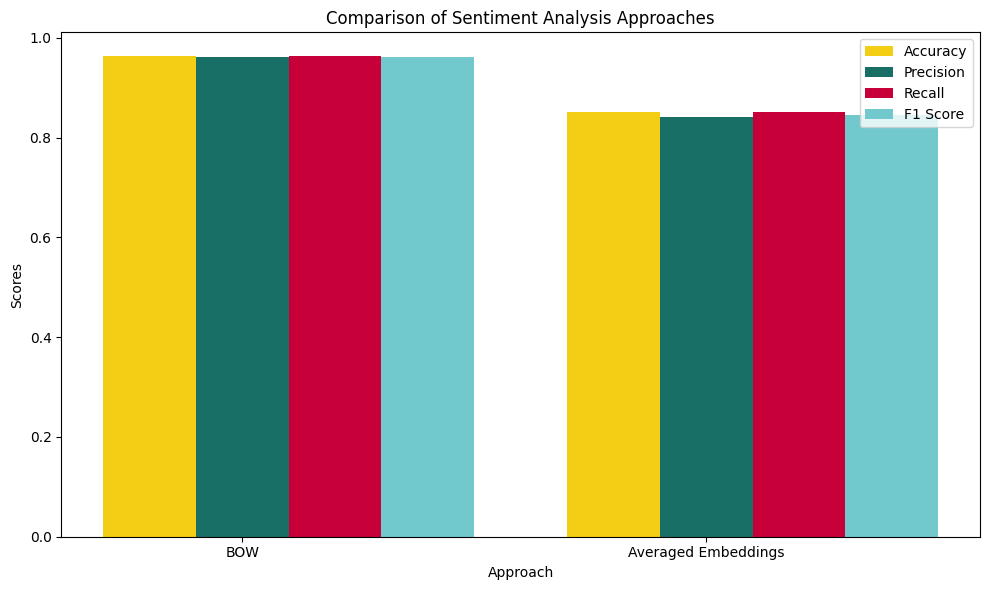

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluation metrics for BOW and Averaged Embeddings
approaches = ['BOW', 'Averaged Embeddings']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the scores for each metric
scores = [
    [accuracy_bow, precision_bow, recall_bow, f1_score_bow],
    [accuracy_avg_embeddings, precision_avg_embeddings, recall_avg_embeddings, f1_score_avg_embeddings]
]

# Define colors for the metrics
colors = ['#F4CE14', '#186F65', '#C70039', '#71C9CE']

bar_width = 0.2
index = np.arange(len(approaches))

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    score = [score[i] for score in scores]
    ax.bar(index + i * bar_width, score, bar_width, label=metric, color=colors[i])

ax.set_xlabel('Approach')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Sentiment Analysis Approaches')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(approaches)
ax.legend()

plt.tight_layout()
#plt.show()
plt.savefig('Comparison of Sentiment Analysis Approaches.png', dpi=1000)


Machine Learning model for Average Embedding and Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6396984924623116
Precision: 0.6093721369700783
Recall: 0.6396984924623116
F1 Score: 0.615140186637634


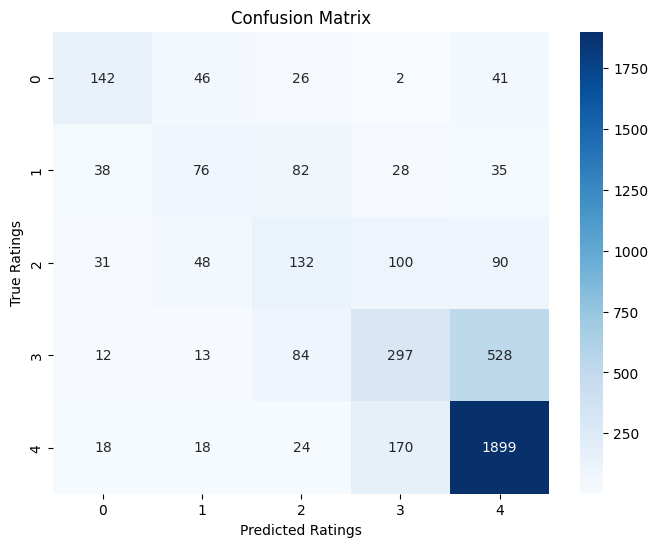

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Dataset.csv')

# Load the spaCy model with pre-trained word embeddings (assuming 'en_core_web_md' is the model name)
nlp = spacy.load('en_core_web_md')

# Define a function to create averaged word embeddings for each review text
def averaged_word_embeddings(text):
    doc = nlp(text)
    vector_sum = np.zeros(len(doc[0].vector))
    word_count = 0
    for token in doc:
        vector_sum += token.vector
        word_count += 1
    if word_count > 0:
        return vector_sum / word_count
    else:
        return np.zeros(len(vector_sum))

# Create averaged embeddings for your dataset using the spaCy model
df['Averaged Embeddings'] = df['Review_Text'].apply(averaged_word_embeddings)

# Split your data into training and testing sets (adjust the split ratio as needed)
X_train, X_test, y_train, y_test = train_test_split(df['Averaged Embeddings'], df['Rating'], test_size=0.2, random_state=42)

# Create and train a Logistic Regression model
logistic_regression = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
logistic_regression.fit(X_train.tolist(), y_train)

# Predict ratings for the test data
logistic_regression_predictions = logistic_regression.predict(X_test.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, logistic_regression_predictions)
precision = precision_score(y_test, logistic_regression_predictions, average='weighted')
recall = recall_score(y_test, logistic_regression_predictions, average='weighted')
f1 = f1_score(y_test, logistic_regression_predictions, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Create and plot a confusion matrix
conf_matrix = confusion_matrix(y_test, logistic_regression_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Ratings')
plt.ylabel('True Ratings')
plt.title('Confusion Matrix')
plt.show()

#df_AvgEmbedding = df.copy()
# Save the DataFrame with the predicted ratings as a new CSV file
# df.to_csv('predicted_ratings_with_embeddings.csv', index=False)


Answer to 3:

In [75]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming you have a DataFrame named 'df_textblob'
correlation, p_value = pearsonr(df_textblob['Rating'], df_textblob['TextBlob_Polarity_Score'])

print(f"Pearson Correlation of user rating and textblob predicted rating: {correlation}")
print(f"P-Value: {p_value}")


Pearson Correlation of user rating and textblob predicted rating: 0.5205287751014045
P-Value: 0.0


In [76]:
import pandas as pd

# Assuming you have a DataFrame named 'df_BOW'
# Define a function to map user ratings to sentiment categories
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to the 'Rating' column and create a new 'Sentiment' column
df_BOW['Sentiment_Rating'] = df_BOW['Rating'].apply(map_rating_to_sentiment)

# If you want to overwrite the existing 'Sentiment Name' column:
# df_BOW['Sentiment Name'] = df_BOW['Rating'].apply(map_rating_to_sentiment)

# Print the updated DataFrame
print(df_BOW)




                                                Yelp URL  Rating        Date  \
0      https://www.yelp.com/biz/sidney-dairy-barn-sidney       5   1/22/2022   
1      https://www.yelp.com/biz/sidney-dairy-barn-sidney       4   6/26/2022   
2      https://www.yelp.com/biz/sidney-dairy-barn-sidney       5    8/7/2021   
3      https://www.yelp.com/biz/sidney-dairy-barn-sidney       4   7/28/2016   
4      https://www.yelp.com/biz/sidney-dairy-barn-sidney       5   6/23/2015   
...                                                  ...     ...         ...   
19891  https://www.yelp.com/biz/la-pasticceria-las-vegas       4   7/17/2021   
19892  https://www.yelp.com/biz/la-pasticceria-las-vegas       4  10/21/2019   
19893  https://www.yelp.com/biz/la-pasticceria-las-vegas       4  10/12/2019   
19894  https://www.yelp.com/biz/la-pasticceria-las-vegas       5   4/11/2021   
19895  https://www.yelp.com/biz/la-pasticceria-las-vegas       4    9/3/2019   

                                       

In [78]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming you have two DataFrames 'df_BOW' and 'df_Predicted'
# You can use a mapping to convert categorical values to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Convert categorical values to numerical values
df_BOW['Sentiment_Rating_Num'] = df_BOW['Sentiment_Rating'].map(sentiment_mapping)
df_BOW['Predicted_Sentiment_Num'] = df_BOW['BoW_Predicted_Sentiment'].map(sentiment_mapping)

# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(df_BOW['Sentiment_Rating_Num'], df_BOW['Predicted_Sentiment_Num'])

print(f"Pearson Correlation of user rating and BOW+Logistic model predicted rating: {correlation}")
print(f"P-Value: {p_value}")

Pearson Correlation of user rating and BOW+Logistic model predicted rating: 0.9397349926503445
P-Value: 0.0


In [81]:

correlation, p_value = pearsonr(df_AvgEmbedding['Rating'], df_AvgEmbedding['AvgEmbedding_Predicted_Rating'])

print(f"Pearson Correlation of user rating and AvgEmbedding+Logistic regression predicted rating: {correlation}")
print(f"P-Value: {p_value}")

Pearson Correlation of user rating and AvgEmbedding+Logistic regression predicted rating: 0.7336867743951941
P-Value: 0.0


Answer to question 4:

sentiment analysis using the VADER

In [82]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon if you haven't already
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [83]:
# Load your dataset into a DataFrame
df = pd.read_csv('Dataset.csv')
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Create a function to calculate sentiment scores
def calculate_vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    # Determine the sentiment based on the compound score
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'Review Text' column
df['VADER Sentiment'] = df['Review_Text'].apply(calculate_vader_sentiment)

# Print or save the updated DataFrame
df_vadar = df.copy()



Illustrate the extent of matching in positive, negative and neutral cases as bar-plot showing the percentage of matching for each case.

In [84]:
df_textblob.head(2)

,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score,Textblob_Sentiment
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...,0.773333,positive
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...,0.273661,positive


In [85]:
df_vadar.head(2)

,Yelp URL,Rating,Date,Review_Text,VADER Sentiment
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...,positive
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...,positive


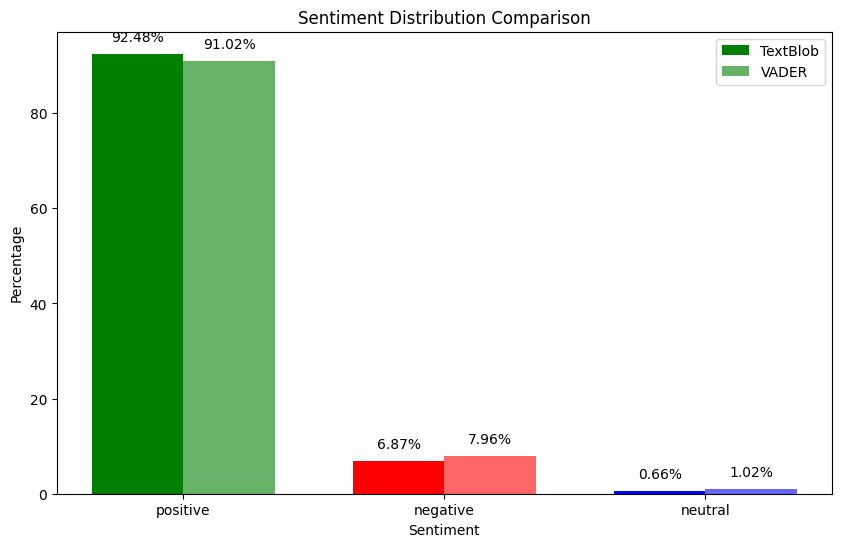

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have DataFrames 'df_textblob' and 'df_vader' with the respective sentiment columns

# Define custom colors for the sentiments
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
sentiments = ['positive', 'negative', 'neutral']

# Calculate sentiment counts and percentages for both DataFrames
sentiment_counts_textblob = df_textblob['Textblob_Sentiment'].value_counts()
total_records_textblob = len(df_textblob)
percentage_sentiments_textblob = [(sentiment_counts_textblob[sent] / total_records_textblob) * 100 for sent in sentiments]

sentiment_counts_vader = df_vadar['VADER Sentiment'].value_counts()
total_records_vader = len(df_vadar)
percentage_sentiments_vader = [(sentiment_counts_vader[sent] / total_records_vader) * 100 for sent in sentiments]

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars
bar_width = 0.35
index = np.arange(len(sentiments))

# Plot the sentiment distribution for df_textblob
ax.bar(index - bar_width / 2, percentage_sentiments_textblob, bar_width, color=colors.values(), label='TextBlob')

# Plot the sentiment distribution for df_vader
ax.bar(index + bar_width / 2, percentage_sentiments_vader, bar_width, color=colors.values(), alpha=0.6, label='VADER')

# Annotate the bars with percentage values
for i, v in enumerate(percentage_sentiments_textblob):
    ax.text(i - bar_width / 2, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

for i, v in enumerate(percentage_sentiments_vader):
    ax.text(i + bar_width / 2, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Set axis labels, ticks, and legend
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Distribution Comparison')
ax.set_xticks(index)
ax.set_xticklabels(sentiments)
ax.legend()

#plt.show()
plt.savefig('Sentiment Distribution Comparison.png', dpi=1000)

Wordcloud

In [88]:
processed_df.head(2)

,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score
12228,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2005-06-24,know cleveland italian neighborhood beautiful ...,0.608854
12219,https://www.yelp.com/biz/prestis-bakery-cleveland,5,2005-07-27,drunken clevelanders emerge party bar east sid...,0.084375


<ipython-input-91-f86435af5547>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  UserRating_df = df[processed_df['Rating'] == (4,5)]


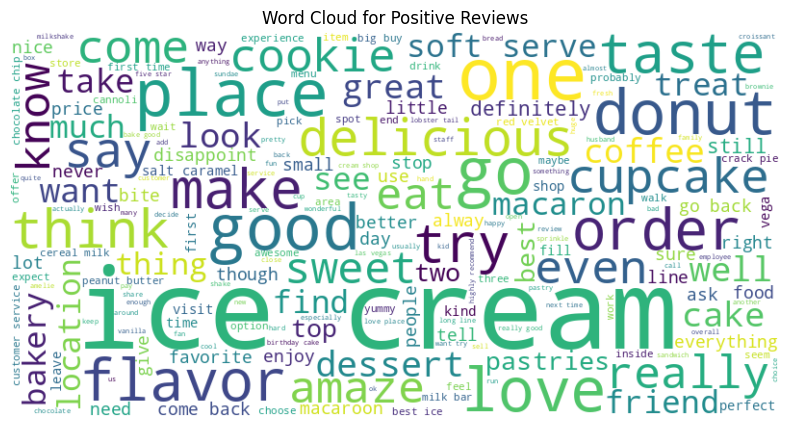

In [91]:
from wordcloud import WordCloud, STOPWORDS
UserRating_df = df[processed_df['Rating'] == (4,5)]
concat_text = ' '.join(processed_df['Review_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(concat_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
#plt.show()
plt.savefig('Positive.png', dpi=1000)


<ipython-input-93-404fa04bbff5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  UserRating_df = df[processed_df['Rating'] == (3)]


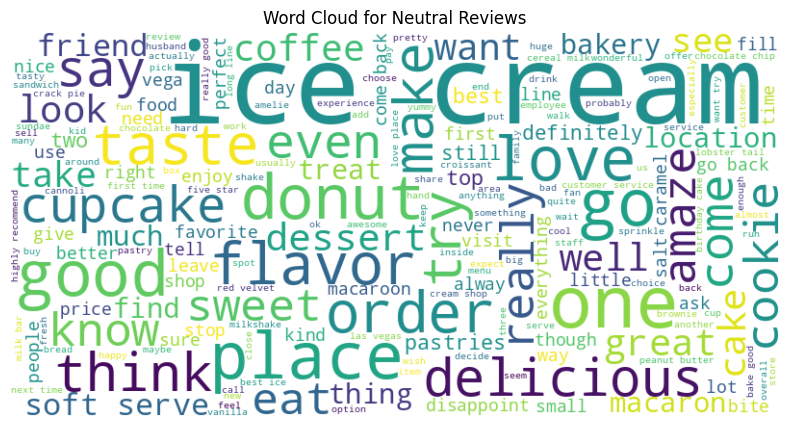

In [93]:
from wordcloud import WordCloud, STOPWORDS
UserRating_df = df[processed_df['Rating'] == (3)]
concat_text = ' '.join(processed_df['Review_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(concat_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
#plt.show()
plt.savefig('Neutral.png', dpi=1000)


<ipython-input-94-22f6fc424e6f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  UserRating_df = df[processed_df['Rating'] == (1,2)]


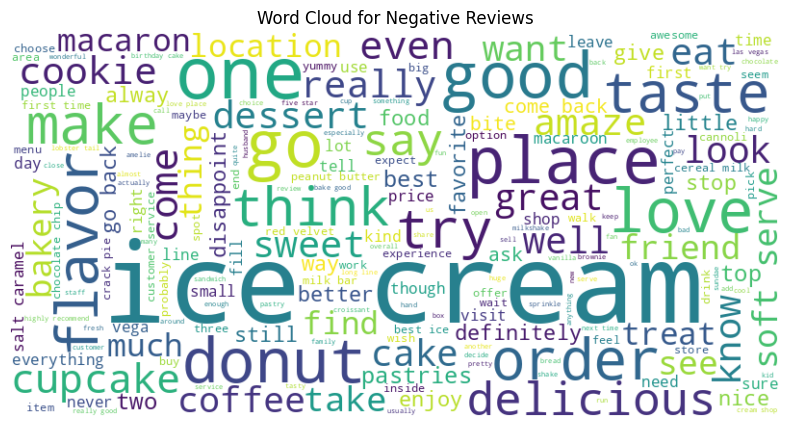

In [94]:
from wordcloud import WordCloud, STOPWORDS
UserRating_df = df[processed_df['Rating'] == (1,2)]

# Concatenate all the 'Content' entries for 'sadness' into a single string
concat_text = ' '.join(processed_df['Review_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(concat_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
#plt.show()
plt.savefig('Negative.png', dpi=1000)


Answer 5:

In [95]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

5.	We want to distinguish key attributes in user’s review. We concentrate on four main attributes: cost or price, food, location, service. Suggest a set of related keywords for each these four attributes. Then write a script that identifies these attributes from the review text, then use part-of-speech tagging to identify adjective/adverb linked to the corresponding attribute.

In [96]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# Load your dataset ('processed_df') into a DataFrame
# Replace 'processed_df.csv' with your dataset file name
df = processed_df

# Define sets of keywords for each attribute
attributes_keywords = {
    "Cost/Price": {
        "price", "cost", "expensive", "affordable", "pricy", "economical", "reasonable",
        "budget-friendly", "overpriced", "inexpensive", "high-priced", "cheap", "reasonable", "expensive",
        "wallet-friendly", "costly", "afford", "rate", "charge", "fee", "value", "spend", "money", "affordability",
        "expensiveness", "bargain", "expenditure", "pricing", "rate", "fee"
    },
    "Food": {
        "food", "tasty", "delicious", "bland", "flavorful", "yummy", "appetizing",
        "palatable", "savory", "delectable", "mouthwatering", "taste", "cuisine", "culinary",
        "gourmet", "gastronomic", "sapid", "scrumptious", "flavorsome", "toothsome", "savoury",
        "flavourful", "nourishment", "eatables", "grub", "refreshment", "victuals", "chow", "eats"
    },
    "Location": {
        "location", "convenient", "central", "remote", "nearby", "accessible", "distant",
        "proximate", "faraway", "neighborhood", "vicinity", "surroundings", "site", "area",
        "spot", "venue", "locale", "region", "district", "zone", "destination", "proximity",
        "closeness", "remoteness", "farness", "accessibility", "remoteness", "distance", "closeness"
    },
    "Service": {
        "service", "slow", "prompt", "courteous", "efficient", "friendly", "professional",
        "responsive", "helpful", "attentive", "speedy", "timely", "quick", "speed", "efficiency",
        "accommodating", "customer service", "quality service", "hospitality", "accommodation",
        "courteousness", "hospitality", "assistance", "support", "courtesy", "amiable", "cordial",
        "warm", "personable", "client service"
    },
}

# Function to identify attributes and extract adjective/adverb phrases
def identify_attributes_and_phrases(review_text):
    tokens = word_tokenize(review_text)
    tags = pos_tag(tokens)

    # Initialize dictionaries to store adjective/adverb phrases for each attribute
    attribute_phrases = {attr: [] for attr in attributes_keywords}

    # Extract adjective/adverb phrases linked to the attributes
    for i, (word, tag) in enumerate(tags):
        # Check if the word is in any attribute keywords
        for attribute, keywords in attributes_keywords.items():
            if word.lower() in keywords:
                # Find adjective/adverb phrases linked to the attribute
                phrase = ""
                for j in range(i, -1, -1):
                    w, t = tags[j]
                    if t in {"JJ", "JJR", "JJS", "RB", "RBR", "RBS"}:
                        if phrase:
                            phrase = w + " " + phrase
                        else:
                            phrase = w
                    else:
                        if phrase:
                            attribute_phrases[attribute].append(phrase)
                            break

    # Remove common stopwords
    stop_words = set(stopwords.words("english"))
    for attribute, phrases in attribute_phrases.items():
        attribute_phrases[attribute] = [phrase for phrase in phrases if phrase.lower() not in stop_words]

    return attribute_phrases

# Apply the function to the 'Review Text' column
df['Attribute Phrases'] = df['Review_Text'].apply(identify_attributes_and_phrases)

# Print the DataFrame with identified attribute phrases
print(df['Attribute Phrases'])


12228    {'Cost/Price': [], 'Food': [], 'Location': ['i...
12219    {'Cost/Price': [], 'Food': [], 'Location': [],...
14794    {'Cost/Price': [], 'Food': [], 'Location': [],...
14837    {'Cost/Price': [], 'Food': ['best'], 'Location...
12097    {'Cost/Price': [], 'Food': [], 'Location': [],...
                               ...                        
19825    {'Cost/Price': [], 'Food': [], 'Location': [],...
19517    {'Cost/Price': [], 'Food': ['better'], 'Locati...
18251    {'Cost/Price': [], 'Food': [], 'Location': [],...
18132    {'Cost/Price': [], 'Food': ['still delicious',...
19611    {'Cost/Price': [], 'Food': [], 'Location': ['o...
Name: Attribute Phrases, Length: 19896, dtype: object


In [ ]:
# Extract and view the relevant attribute phrases from your dataset
for idx, row in df.iterrows():
    print(f"Review #{idx + 1}:")
    print("Review Text: ", row['Review_Text'])
    print("Attribute Phrases:")
    for attribute, phrases in row['Attribute Phrases'].items():
        if phrases:
            print(f"{attribute}: {', '.join(phrases)}")
        else:
            print(f"{attribute}: No relevant phrases found.")
    print("\n")


Streaming output truncated to the last 5000 lines.
Food: No relevant phrases found.
Location: No relevant phrases found.
Service: really nice nice thin, really slow


Review #19342:
Review Text:  saturday morning eight usual wait long actually mind wait turn want say guy make crepe jerk stand day pour batter griddle stupid face wear stupid hat extremely rude maybe would hate job day would rude third time back even though love crepe sure go back hey crepe maker get real job put smile face hurt business hope owner business owner ever hear customer service owner someone need fire come back make sure husband come tell person jerk
Attribute Phrases:
Cost/Price: No relevant phrases found.
Food: No relevant phrases found.
Location: No relevant phrases found.
Service: ever hear


Review #19343:
Review Text:  crepe nutella bananas powder sugar lunch champion
Attribute Phrases:
Cost/Price: No relevant phrases found.
Food: No relevant phrases found.
Location: No relevant phrases found.
Service: N

In [101]:
processed_df.head(5)

,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score,Attribute Phrases
12228,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2005-06-24,know cleveland italian neighborhood beautiful ...,0.608854,"{'Cost/Price': [], 'Food': [], 'Location': ['i..."
12219,https://www.yelp.com/biz/prestis-bakery-cleveland,5,2005-07-27,drunken clevelanders emerge party bar east sid...,0.084375,"{'Cost/Price': [], 'Food': [], 'Location': [],..."
14794,https://www.yelp.com/biz/jarlings-custard-cup-...,4,2005-10-19,open warmer weather designyourown custard crea...,0.209375,"{'Cost/Price': [], 'Food': [], 'Location': [],..."
14837,https://www.yelp.com/biz/jarlings-custard-cup-...,5,2005-10-20,custard cup friends place go summer best taste...,0.618571,"{'Cost/Price': [], 'Food': ['best'], 'Location..."
12097,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2006-05-05,would know previous three review place actuall...,0.268308,"{'Cost/Price': [], 'Food': [], 'Location': [],..."


Answer 7

In [102]:
df.head(2)

,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score,Attribute Phrases
12228,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2005-06-24,know cleveland italian neighborhood beautiful ...,0.608854,"{'Cost/Price': [], 'Food': [], 'Location': ['i..."
12219,https://www.yelp.com/biz/prestis-bakery-cleveland,5,2005-07-27,drunken clevelanders emerge party bar east sid...,0.084375,"{'Cost/Price': [], 'Food': [], 'Location': [],..."


In [103]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import sqlite3
from scipy.stats import pearsonr

# Download WordNet data if not already downloaded
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [104]:
def calculate_percentage_correct_wording(review_text):
    tokens = word_tokenize(review_text)
    valid_tokens = [token for token in tokens if wordnet.synsets(token)]
    return len(valid_tokens) / len(tokens) if len(tokens) > 0 else 0


In [105]:
# Calculate the percentage of correct wording for each review
df['Percentage Correct Wording'] = df['Review_Text'].apply(calculate_percentage_correct_wording)
df.head(5)


,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score,Attribute Phrases,Percentage Correct Wording
12228,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2005-06-24,know cleveland italian neighborhood beautiful ...,0.608854,"{'Cost/Price': [], 'Food': [], 'Location': ['i...",0.888889
12219,https://www.yelp.com/biz/prestis-bakery-cleveland,5,2005-07-27,drunken clevelanders emerge party bar east sid...,0.084375,"{'Cost/Price': [], 'Food': [], 'Location': [],...",0.886792
14794,https://www.yelp.com/biz/jarlings-custard-cup-...,4,2005-10-19,open warmer weather designyourown custard crea...,0.209375,"{'Cost/Price': [], 'Food': [], 'Location': [],...",0.966667
14837,https://www.yelp.com/biz/jarlings-custard-cup-...,5,2005-10-20,custard cup friends place go summer best taste...,0.618571,"{'Cost/Price': [], 'Food': ['best'], 'Location...",0.954545
12097,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2006-05-05,would know previous three review place actuall...,0.268308,"{'Cost/Price': [], 'Food': [], 'Location': [],...",0.927273


In [106]:
# Calculate the Pearson correlation for negative and positive cases
negative_reviews = df[(df['Rating'] == 1) | (df['Rating'] == 2)]
positive_reviews = df[(df['Rating'] == 3) | (df['Rating'] == 4)]

correlation_negative, _ = pearsonr(negative_reviews['Percentage Correct Wording'], negative_reviews['Rating'])
correlation_positive, _ = pearsonr(positive_reviews['Percentage Correct Wording'], positive_reviews['Rating'])

print(f"Pearson Correlation for Negative Reviews: {correlation_negative:.4f}")
print(f"Pearson Correlation for Positive Reviews: {correlation_positive:.4f}")


Pearson Correlation for Negative Reviews: -0.0401
Pearson Correlation for Positive Reviews: 0.0084


In [111]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation for negative and positive cases
correlation_negative, p_value_negative = pearsonr(negative_reviews['Percentage Correct Wording'], negative_reviews['Rating'])
correlation_positive, p_value_positive = pearsonr(positive_reviews['Percentage Correct Wording'], positive_reviews['Rating'])

print(f"Pearson Correlation for Negative Reviews: {correlation_negative:.4f}")
print(f"P-value for Negative Reviews: {p_value_negative:.4f}")

print(f"Pearson Correlation for Positive Reviews: {correlation_positive:.4f}")
print(f"P-value for Positive Reviews: {p_value_positive:.4f}")

# Perform hypothesis testing
alpha = 0.05  # Significance level

if p_value_negative < alpha:
    print("The correlation for negative reviews is statistically significant.")
else:
    print("The correlation for negative reviews is not statistically significant.")

if p_value_positive < alpha:
    print("The correlation for positive reviews is statistically significant.")
else:
    print("The correlation for positive reviews is not statistically significant.")


Pearson Correlation for Negative Reviews: -0.0401
P-value for Negative Reviews: 0.0451
Pearson Correlation for Positive Reviews: 0.0084
P-value for Positive Reviews: 0.5003
The correlation for negative reviews is statistically significant.
The correlation for positive reviews is not statistically significant.


Answer to 8

I will compare my model with this model availabe at kaggle (https://www.kaggle.com/code/satishgunjal/user-review-model-with-fasttext)

Some Common ML Models

Random Forest

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_df['Review_Text'], processed_df['Rating'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create and train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.58
Precision: 0.54
Recall: 0.58
F1 Score: 0.48
Confusion Matrix:
[[  41    5    6   21  181]
 [  17   10   33   39  165]
 [   3    1   36   92  289]
 [   1    0    4  119  772]
 [   1    0    1   51 2092]]


Gradient Boosting

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_df['Review_Text'], processed_df['Rating'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create and train a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.61
Precision: 0.57
Recall: 0.61
F1 Score: 0.55
Confusion Matrix:
[[  74   29   14   22  115]
 [  35   40   47   38  104]
 [   9   22   82  101  207]
 [   3    3   28  201  661]
 [   2    0    6   87 2050]]


SVM

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_df['Review_Text'], processed_df['Rating'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create and train a Support Vector Machine (SVM) classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.66
Precision: 0.64
Recall: 0.66
F1 Score: 0.65
Confusion Matrix:
[[ 140   54   26   10   24]
 [  56   79   81   22   26]
 [  24   45  164  110   78]
 [   8   10   80  334  464]
 [   4    8   24  181 1928]]


Neural network

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_df['Review_Text'], processed_df['Rating'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create and train a Neural Network classifier
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = nn_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.60
Precision: 0.59
Recall: 0.60
F1 Score: 0.59
Confusion Matrix:
[[ 128   61   33   10   22]
 [  55   71   91   27   20]
 [  29   57  150  110   75]
 [  13   20  109  316  438]
 [  15   21   72  327 1710]]


Machine Learning Model

In [116]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.3 MB/s eta 0:00:00


In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('Dataset.csv')  # Replace 'your_dataset.csv' with your dataset file path

# Data cleaning and handling missing values (if any)
data.dropna(subset=['Review_Text', 'Rating'], inplace=True)

# Encode the 'Rating' column (if not already numerical)
data['Rating'] = data['Rating'].astype(int)

# Split the data into training and testing sets
X = data['Review_Text']
y = data['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Engineering

Use TF-IDF (Term Frequency-Inverse Document Frequency) to convert text data into numerical features.

In [118]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust the number of features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Step 3: Hyperparameter Tuning

Use GridSearchCV to tune hyperparameters of different machine learning models.
Here's an example for hyperparameter tuning with a Linear Support Vector Classifier (SVM):

In [119]:
param_grid = {'C': [0.00002, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=4)
grid_search.fit(X_train_tfidf, y_train)
best_svc = grid_search.best_estimator_


In [120]:
# Linear SVC
svc = LinearSVC(C=best_svc.C)
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Linear SVC Accuracy:", accuracy_svc)


Linear SVC Accuracy: 0.6552763819095477


In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

# Define a function for hyperparameter tuning and model evaluation
def tune_and_evaluate_model(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=4)
    grid_search.fit(X_train_tfidf, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5'])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Accuracy: {accuracy}")
    print(f"{model_name} - Classification Report:\n{classification_rep}")
    print(f"{model_name} - Confusion Matrix:\n{conf_matrix}")

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [0.00002, 0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 2, 4, 5, 10]}
tune_and_evaluate_model(LogisticRegression(), param_grid_lr, "Logistic Regression")

# Hyperparameter tuning for Decision Tree
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50]}
tune_and_evaluate_model(DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree")



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression - Best Parameters: {'C': 1.5}
Logistic Regression - Accuracy: 0.6633165829145728
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       257
           2       0.42      0.26      0.32       259
           3       0.46      0.40      0.43       401
           4       0.50      0.38      0.43       934
           5       0.75      0.90      0.82      2129

    accuracy                           0.66      3980
   macro avg       0.57      0.50      0.53      3980
weighted avg       0.64      0.66      0.64      3980

Logistic Regression - Confusion Matrix:
[[ 148   46   17   14   32]
 [  38   67   89   31   34]
 [  15   37  159  109   81]
 [   3    7   67  353  504]
 [   2    3   14  197 1913]]
Decision Tree - Best Parameters: {'max_depth': 10}
Decision Tree - Accuracy: 0.5324120603015076
Decision Tree - Classification Report:
              precision    recall  f1-score   sup

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [20, 30, 50, 70, 100, 150], 'max_depth': [None, 10, 20, 30]}
tune_and_evaluate_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")

# Hyperparameter tuning for Multinomial Naive Bayes
param_grid_nb = {'alpha': [0.00001, 0.001, 0.1, 0.3, 0.5, 1.0, 2.0]}
tune_and_evaluate_model(MultinomialNB(), param_grid_nb, "Multinomial Naive Bayes")


Random Forest - Best Parameters: {'max_depth': None, 'n_estimators': 20}
Random Forest - Accuracy: 0.5726130653266331
Random Forest - Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.14      0.23       257
           2       0.30      0.05      0.09       259
           3       0.38      0.12      0.19       401
           4       0.38      0.17      0.23       934
           5       0.61      0.95      0.74      2129

    accuracy                           0.57      3980
   macro avg       0.45      0.29      0.29      3980
weighted avg       0.51      0.57      0.49      3980

Random Forest - Confusion Matrix:
[[  36   11   19   30  161]
 [  13   13   26   54  153]
 [   7   15   50   81  248]
 [   2    3   26  156  747]
 [   1    2   11   91 2024]]
Multinomial Naive Bayes - Best Parameters: {'alpha': 0.1}
Multinomial Naive Bayes - Accuracy: 0.6160804020100502
Multinomial Naive Bayes - Classification Report:
              pre

#Model Building: Logistic Regression

In [130]:
pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.6 MB/s eta 0:00:00


In [138]:
processed_df.head(2)

,Yelp URL,Rating,Date,Review_Text,TextBlob_Polarity_Score,Attribute Phrases,Percentage Correct Wording
12228,https://www.yelp.com/biz/prestis-bakery-cleveland,4,2005-06-24,know cleveland italian neighborhood beautiful ...,0.608854,"{'Cost/Price': [], 'Food': [], 'Location': ['i...",0.888889
12219,https://www.yelp.com/biz/prestis-bakery-cleveland,5,2005-07-27,drunken clevelanders emerge party bar east sid...,0.084375,"{'Cost/Price': [], 'Food': [], 'Location': [],...",0.886792


In [140]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extract features (e.g., Bag-of-Words) and labels
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_df['Review_Text'])
y = processed_df['Rating']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Selection: Use SelectKBest with chi-squared as an example.
k_best = SelectKBest(chi2, k=1000)
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

# Hyperparameter Tuning using Bayesian Optimization
log_reg = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
param_grid = {
    'C': (1e-6, 1e+6, 'log-uniform'),
}
opt = BayesSearchCV(log_reg, param_grid, n_iter=30, cv=10, n_jobs=-1)
opt.fit(X_train, y_train)

# Best hyperparameters
best_C = opt.best_params_['C']

# Cross-Validation using the tuned hyperparameters
log_reg_tuned = LogisticRegression(penalty='l2', C=best_C, max_iter=1000, random_state=42)
cv_scores = cross_val_score(log_reg_tuned, X_train, y_train, cv=10)

# Train the model with the full training set
log_reg_tuned.fit(X_train, y_train)

# Predict sentiment labels for the test data
y_pred = log_reg_tuned.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


Best C (Hyperparameter): 0.3570545230169226
Cross-Validation Scores: [0.67399497 0.65075377 0.64572864 0.65012563 0.65954774 0.67399497
 0.65744815 0.65241986 0.672533   0.67127593]
Average Cross-Validation Score: 0.66
Test Set Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.50      0.54       254
           2       0.40      0.31      0.35       264
           3       0.43      0.36      0.39       421
           4       0.51      0.34      0.41       896
           5       0.74      0.90      0.81      2145

    accuracy                           0.65      3980
   macro avg       0.53      0.48      0.50      3980
weighted avg       0.62      0.65      0.63      3980



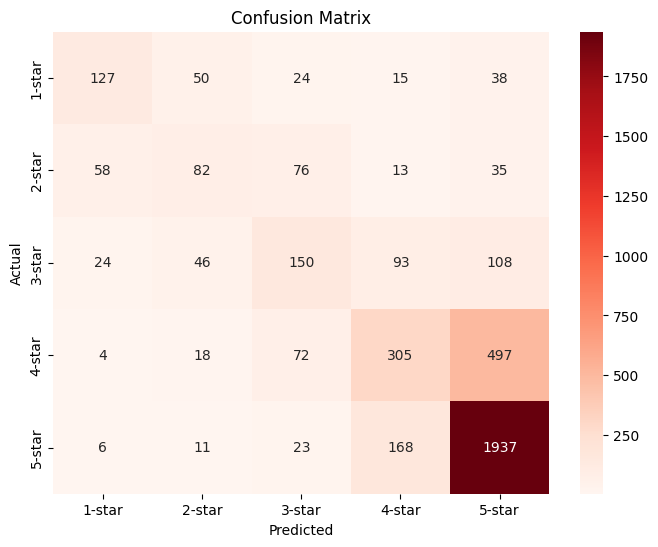

In [144]:
# Print the results
print(f"Best C (Hyperparameter): {best_C}")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Average Cross-Validation Score: {cv_scores.mean():.2f}")
print(f"Test Set Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Reds', xticklabels=['1-star', '2-star', '3-star', '4-star', '5-star'], yticklabels=['1-star', '2-star', '3-star', '4-star', '5-star'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#plt.show()
plt.savefig('Confusion Matrix.png', dpi=1000)